In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="7"


import random
import numpy as np
import seaborn as sns
import pickle
import matplotlib
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch
import swifter
from torch import nn, Tensor
from torch.autograd import Variable
import pandas as pd
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import KBinsDiscretizer
from torch.optim import Adam, lr_scheduler
from torch.nn import BCEWithLogitsLoss
from torchinfo import summary
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from mlflow import MlflowClient
import mlflow

/tmp/ipykernel_2487683/3352359748.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
class MLFlowLogger:
    def __init__(self,exp_name,
                 config:dict,
                 tracking_url:str = "http://127.0.0.1:5000",
                 ) -> None:
        
        self.client = MlflowClient(tracking_uri=tracking_url)
        self._experiment = mlflow.set_experiment(
            exp_name
        )
        
        with mlflow.start_run() as run:
            self.run_info = run.info
        
        self.track_params(config=config)
        
    
    def track_params(self, config:dict):
        params = MLFlowLogger.unnest_dictionary(config)
        
        with mlflow.start_run(run_id=self.run_info.run_id) as run:
            if not self.run_info:
                self.run_info = run.info
            
            mlflow.log_params(params)
        
        
    def track_metrics(self, metrics:dict):
        params = MLFlowLogger.unnest_dictionary(metrics)
        
        with mlflow.start_run(run_id=self.run_info.run_id) as run:
            if not self.run_info:
                self.run_info = run.info
            
            mlflow.log_metrics(metrics)
        
    
    @staticmethod
    def unnest_dictionary(d:dict, level:str=None, unnested_dict:dict = {}) -> dict:
        for k, v in d.items():
            if level:
                next_level=f"{level}_{k}"
            else:
                next_level = k
                
            if not isinstance(v,dict):
                #print(level,k)
                unnested_dict[next_level] = v
            else:
                #print(d,level,k,v,2)
                MLFlowLogger.unnest_dictionary(v, next_level, unnested_dict)
                
        return unnested_dict

In [4]:
#config of run

config = {
    "dataset":{
        "name":'drug1_drug1_interaction_agent',
        "encoding":"proteinbert",
        "data_loc": "processed_data",
        'model_checkpoint': "facebook/esm2_t6_8M_UR50D",
    },
    "model":{
        "max_length_tokens": 300,
        'input_dim_drug1': 320,
        'input_dim_drug2': 320,
        'n_drug1_channels': 320,
        'n_drug2_channels': 320,
        'hidden_dim_drug1': 256,
        'hidden_dim_drug2': 256,
        'result_folder': './result/',
        },
    
    "optimizer":{
        'LR': 0.01,
        "weight_decay":1e-5
    },
    'batch_size': 128,
    'train_epoch': 20,
    "device": "cuda",
    "seed": 49
}

#set seeds
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

#device
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#mlflow
run_tracker = MLFlowLogger(
    f"{config['dataset']['name']}_{config['dataset']['encoding']}",
    config)

In [5]:
def get_esm2_components(config,device):

    model_checkpoint = config["dataset"]['model_checkpoint']

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    esm2_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint).to(device)
    
    return tokenizer, esm2_model

tokenizer, esm2_model = get_esm2_components(config,device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
tokenizer

EsmTokenizer(name_or_path='facebook/esm2_t6_8M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
esm2_model.to(device)
esm2_model.esm.embeddings

EsmEmbeddings(
  (word_embeddings): Embedding(33, 320, padding_idx=1)
  (dropout): Dropout(p=0.0, inplace=False)
  (position_embeddings): Embedding(1026, 320, padding_idx=1)
)

In [8]:
train_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/train.csv")
valid_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/valid.csv")
test_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/test.csv")

# load the data config file
with open(f"{config['dataset']['data_loc']}/config.pkl", "rb") as f:
    data_config = pickle.load(f)

In [9]:
train_dataset["Y"] = train_dataset["Y"].apply(eval)
valid_dataset["Y"] = valid_dataset["Y"].apply(eval)
test_dataset["Y"] = test_dataset["Y"].apply(eval)

In [10]:
def relabel_ds_columns(ds, data_config):
    try:
        col_dict = data_config['ds_name_map']
        
    except:
        col_dict = {k:i for i,k in enumerate(ds["ds_name"].unique())}
        data_config['ds_name_map'] = col_dict
        
    ds["ds_name"] = ds["ds_name"].map(col_dict)
    
    
#relabel_ds_columns(train_dataset, data_config)
#relabel_ds_columns(valid_dataset, data_config)
#relabel_ds_columns(test_dataset, data_config)

In [11]:
_l = pd.Series(train_dataset.loc[:,"Drug1"].unique()).str.len()
_l.min(), _l.max()

(3, 409)

<Axes: >

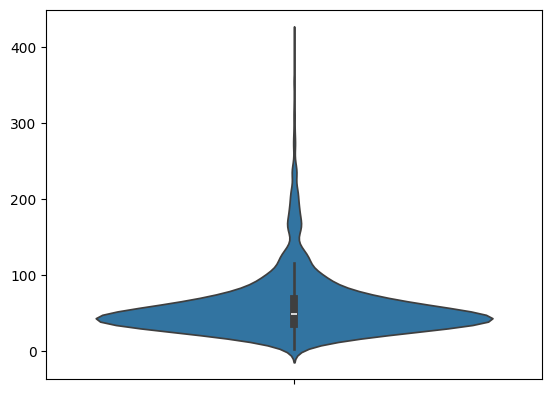

In [12]:
sns.violinplot(_l)

<Axes: >

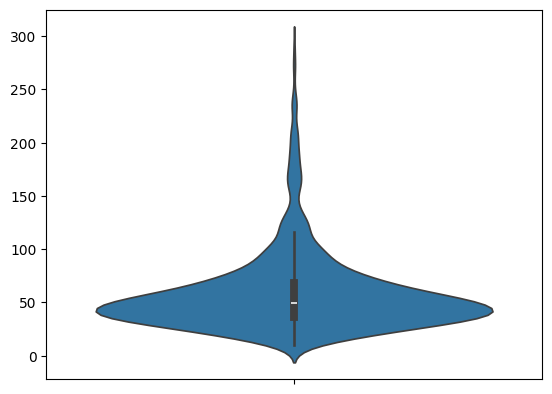

In [13]:
sns.violinplot(_l[(10<=_l)&(_l<=300)])

In [14]:
_l = pd.Series(train_dataset.loc[:,"Drug2"].unique()).str.len()
_l.min(), _l.max()

(3, 804)

<Axes: >

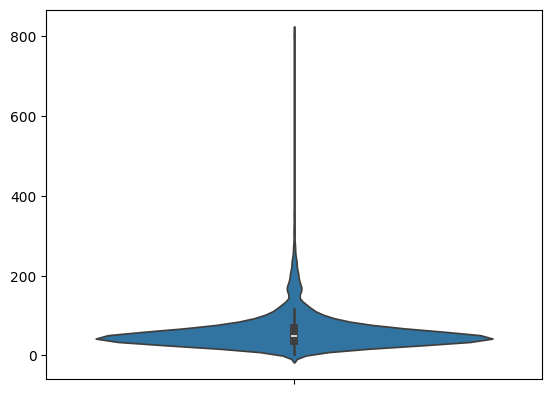

In [15]:
sns.violinplot(_l)

<Axes: >

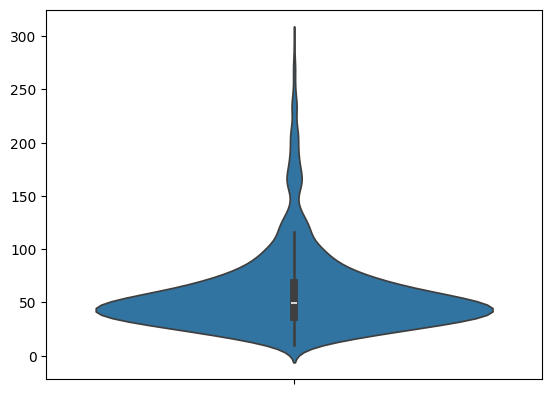

In [16]:
sns.violinplot(_l[(10<=_l)&(_l<=300)])

In [17]:
max_seq_drug = 300

train_dataset = train_dataset[(train_dataset.Drug1.str.len()<=max_seq_drug)&(train_dataset.Drug2.str.len()<=max_seq_drug)]
valid_dataset = valid_dataset[(valid_dataset.Drug1.str.len()<=max_seq_drug)&(valid_dataset.Drug2.str.len()<=max_seq_drug)]
test_dataset = test_dataset[(test_dataset.Drug1.str.len()<=max_seq_drug)&(test_dataset.Drug2.str.len()<=max_seq_drug)]

config["model"]["max_seq_drug1"] = max_seq_drug
config["model"]["max_seq_drug2"] = max_seq_drug


In [18]:
(train_dataset.shape,
 valid_dataset.shape,
 test_dataset.shape,
 )

((184266, 6), (52741, 6), (83601, 6))

In [19]:
def esm2_tokernized_encoding_drug(dataset):
    unique_drug = dataset["Drug1"].unique().tolist()+ dataset["Drug2"].unique().tolist()
    unique_drug1_tokens = tokenizer(
        unique_drug,
        padding='max_length',
        max_length=config['model']['max_length_tokens'],
        truncation=True
        )
    
    unique_dict_input_ids = dict(zip(unique_drug, unique_drug1_tokens["input_ids"]))
    unique_dict_attention_mask = dict(zip(unique_drug, unique_drug1_tokens["attention_mask"]))
    
    drug1_enc_input_ids = dataset["Drug1"].apply(lambda x:unique_dict_input_ids[x]).to_numpy()
    drug1_enc_attention_mask = dataset["Drug1"].apply(lambda x:unique_dict_attention_mask[x]).to_numpy()

    drug2_enc_input_ids = dataset["Drug2"].apply(lambda x:unique_dict_input_ids[x]).to_numpy()
    drug2_enc_attention_mask = dataset["Drug2"].apply(lambda x:unique_dict_attention_mask[x]).to_numpy()

    return drug1_enc_input_ids, drug1_enc_attention_mask, drug2_enc_input_ids, drug2_enc_attention_mask

# Example usage:
train_tokens = esm2_tokernized_encoding_drug(train_dataset)
valid_tokens = esm2_tokernized_encoding_drug(valid_dataset)
test_tokens = esm2_tokernized_encoding_drug(test_dataset)

In [20]:
class DrugDataset(Dataset):
    def __init__(self, 
        ds_name, 
        drug1, 
        drug1_input_ids, 
        drug1_att_mask,  
        drug2, 
        drug2_input_ids, 
        drug2_att_mask,
        y):
        super(DrugDataset, self).__init__()
        self.ds_name = ds_name
        self.drug1 = drug1
        self.drug1_input_ids = drug1_input_ids
        self.drug1_att_mask= drug1_att_mask
        self.drug2 = drug2
        self.drug2_input_ids = drug2_input_ids
        self.drug2_att_mask= drug2_att_mask
        self.y = y

    def __getitem__(self, ind):
        return (#self.ds_name,
                #self.Drug[ind],
                torch.Tensor(self.drug1_input_ids[ind]), 
                torch.Tensor(self.drug1_att_mask[ind]),
                torch.Tensor(self.drug2_input_ids[ind]), 
                torch.Tensor(self.drug2_att_mask[ind]),
                torch.Tensor(self.y[ind]))

    def __len__(self):
        return self.drug1_input_ids.shape[0]

In [21]:
def relabel(label_dict):
    new_label_dict = {}
    for k,v in label_dict.items():
        new_label_dict[k] = {
            "relabel2ori" :{l:i for l,i in enumerate(v)},
            "ori2relabel" :{i:l for l,i in enumerate(v)},
            }
    return new_label_dict

data_config["relabels"] = relabel(data_config["sel_labels"])

### Interanl model for internal effects of drugs

In [22]:
ds = "DrugBank"

In [23]:
def get_multilabel_onehot(labels, max_labels):
    l = np.zeros((len(labels), max_labels))
    for i,label in enumerate(labels):
        l[i,label] = 1
        
    return l

def create_ds_and_dl(_dataset, _tokens, relabel, ds):
    _ds_db = _dataset["ds_name"] == ds
    labels = _dataset.loc[_ds_db,"Y"].apply(lambda x: [relabel[y] for y in x]).tolist()
    labels = get_multilabel_onehot(labels, len(relabel))
    
    _dt = DrugDataset(
            _dataset.loc[_ds_db,"ds_name"].tolist(),
            _dataset.loc[_ds_db,"Drug1"].tolist(),
            _tokens[0][_ds_db], 
            _tokens[1][_ds_db], 
            _dataset.loc[_ds_db,"Drug2"].tolist(),
            _tokens[2][_ds_db], 
            _tokens[3][_ds_db],
            labels,
        )
    
    _dl = DataLoader(
            _dt, 
            batch_size=config['batch_size'], 
            shuffle=False, 
            pin_memory=True, 
        )
    
    return _dt, _dl

train_dt, train_dl = create_ds_and_dl(train_dataset, train_tokens, data_config["relabels"][ds]["ori2relabel"], ds)
valid_dt, valid_dl = create_ds_and_dl(valid_dataset, valid_tokens, data_config["relabels"][ds]["ori2relabel"], ds)
test_dt, test_dl = create_ds_and_dl(test_dataset, test_tokens, data_config["relabels"][ds]["ori2relabel"], ds)

In [24]:
def embedding_step(dataloader, device, ds_name, desc="processing"):
    esm2_model.eval()
    step_embeddings_drug1 = []
    step_embeddings_drug2 = []
    #step_ds = []
    y_true = []

    with tqdm(dataloader, unit="batch", desc=desc) as tepoch:
        for batch in tepoch:
            drug1_input_ids, drug1_att_mask,  drug2_input_ids, drug2_att_mask, y_batch = batch
            
            drug1_input_ids = drug1_input_ids.long().to(device)
            drug1_att_mask = drug1_att_mask.long().to(device)
            
            drug2_input_ids = drug2_input_ids.long().to(device)
            drug2_att_mask = drug2_att_mask.long().to(device)
            
            drug1 = esm2_model.esm.embeddings(drug1_input_ids, drug1_att_mask)
            drug1 = esm2_model.esm.encoder(drug1)
            drug1 = drug1.last_hidden_state
            
            drug2 = esm2_model.esm.embeddings(drug2_input_ids, drug2_att_mask)
            drug2 = esm2_model.esm.encoder(drug2)
            drug2 = drug2.last_hidden_state
            
            step_embeddings_drug1.append(drug1[:,0,:].detach().cpu().numpy())
            step_embeddings_drug2.append(drug2[:,0,:].detach().cpu().numpy())
            y_true.append(y_batch.detach().cpu().numpy())

            # convert feature vector into action class

    return (np.concatenate(step_embeddings_drug1, axis=0), 
            np.concatenate(step_embeddings_drug2, axis=0), 
            np.concatenate(y_true, axis=0),)
            #np.concatenate(step_ds, axis=0))

In [25]:
#calculate train embeddings
train_embeddings_drug1, train_embeddings_drug2, train_y = embedding_step(train_dl, device, ds, desc="train embeddings")

#calculate valid embeddings
valid_embeddings_drug1, valid_embeddings_drug2, valid_y = embedding_step(valid_dl, device, ds, desc="valid embeddings")

#calculate test embeddings
test_embeddings_drug1, test_embeddings_drug2, test_y = embedding_step(test_dl, device, ds, desc="test embeddings")

train embeddings:   0%|          | 0/962 [00:00<?, ?batch/s]

valid embeddings:   0%|          | 0/138 [00:00<?, ?batch/s]

test embeddings:   0%|          | 0/275 [00:00<?, ?batch/s]

In [26]:
def concatenate_embeddings(embeddings_drug1, embeddings_drug2, y):
    return np.concatenate([embeddings_drug1, embeddings_drug2], axis=1), y

def unnest_dictionary(d:dict, level:str=None, unnested_dict:dict = {}) -> dict:
    for k, v in d.items():
        if level:
            next_level=f"{level}_{k}"
        else:
            next_level = k
            
        if not isinstance(v,dict):
            #print(level,k)
            unnested_dict[next_level] = v
        else:
            #print(d,level,k,v,2)
            unnest_dictionary(v, next_level, unnested_dict)
            
    return unnested_dict

train_embeddings, train_y = concatenate_embeddings(train_embeddings_drug1, train_embeddings_drug2, train_y)
valid_embeddings, valid_y = concatenate_embeddings(valid_embeddings_drug1, valid_embeddings_drug2, valid_y)
test_embeddings, test_y = concatenate_embeddings(test_embeddings_drug1, test_embeddings_drug2, test_y)

In [27]:
train_embeddings.shape, train_y.shape

((123100, 640), (123100, 18))

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

#write a function to evaluate a multi label binary classifier
def evaluate_classifier(y, y_pred):
    reports = []
    for c in tqdm(range(y_pred.shape[-1]), desc="evaluating"):
        report = classification_report(y[:,c], y_pred[:,c], output_dict=True)
        report = unnest_dictionary(report)
        report["class"] = data_config["relabels"][ds]["relabel2ori"][c]
        report["class_name"] = data_config["label_map"][ds][data_config["relabels"][ds]["relabel2ori"][c]]
        reports.append(report)
        
    return pd.DataFrame.from_records(reports)

def save_model(model, save_path):
    import joblib
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(model, save_path)
        
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    device='gpu',
    n_jobs=-1,
    random_state=config["seed"]
    )

xgb_model.fit(train_embeddings, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=49, ...)

In [29]:
valid_preds = xgb_model.predict(valid_embeddings)
evaluate_classifier(valid_y, valid_preds).describe()

evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

,0.0_precision,0.0_recall,0.0_f1-score,0.0_support,1.0_precision,1.0_recall,1.0_f1-score,1.0_support,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,class
count,1.800000e+01,1.800000e+01,18.000000,18.0,1.800000e+01,1.800000e+01,1.800000e+01,18.0,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.0,18.000000,1.800000e+01,18.000000,18.0,18.0
mean,9.996588e-01,9.998294e-01,0.999744,17581.0,9.545455e-01,9.130435e-01,9.333333e-01,69.0,9.994901e-01,0.977102,9.564364e-01,9.665387e-01,17650.0,0.999482,9.994901e-01,0.999484,17650.0,67.0
std,1.142410e-16,2.284820e-16,0.000000,0.0,1.142410e-16,1.142410e-16,1.142410e-16,0.0,1.142410e-16,0.000000,2.284820e-16,2.284820e-16,0.0,0.000000,1.142410e-16,0.000000,0.0,0.0
min,9.996588e-01,9.998294e-01,0.999744,17581.0,9.545455e-01,9.130435e-01,9.333333e-01,69.0,9.994901e-01,0.977102,9.564364e-01,9.665387e-01,17650.0,0.999482,9.994901e-01,0.999484,17650.0,67.0
25%,9.996588e-01,9.998294e-01,0.999744,17581.0,9.545455e-01,9.130435e-01,9.333333e-01,69.0,9.994901e-01,0.977102,9.564364e-01,9.665387e-01,17650.0,0.999482,9.994901e-01,0.999484,17650.0,67.0
50%,9.996588e-01,9.998294e-01,0.999744,17581.0,9.545455e-01,9.130435e-01,9.333333e-01,69.0,9.994901e-01,0.977102,9.564364e-01,9.665387e-01,17650.0,0.999482,9.994901e-01,0.999484,17650.0,67.0
75%,9.996588e-01,9.998294e-01,0.999744,17581.0,9.545455e-01,9.130435e-01,9.333333e-01,69.0,9.994901e-01,0.977102,9.564364e-01,9.665387e-01,17650.0,0.999482,9.994901e-01,0.999484,17650.0,67.0
max,9.996588e-01,9.998294e-01,0.999744,17581.0,9.545455e-01,9.130435e-01,9.333333e-01,69.0,9.994901e-01,0.977102,9.564364e-01,9.665387e-01,17650.0,0.999482,9.994901e-01,0.999484,17650.0,67.0


In [30]:
test_preds = xgb_model.predict(test_embeddings)
evaluate_classifier(test_y, test_preds).describe()

evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

,0.0_precision,0.0_recall,0.0_f1-score,0.0_support,1.0_precision,1.0_recall,1.0_f1-score,1.0_support,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,class
count,1.800000e+01,1.800000e+01,1.800000e+01,18.0,1.800000e+01,1.800000e+01,1.800000e+01,18.0,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,18.0,1.800000e+01,1.800000e+01,1.800000e+01,18.0,18.0
mean,9.998286e-01,9.998286e-01,9.998286e-01,35016.0,9.640719e-01,9.640719e-01,9.640719e-01,167.0,9.996589e-01,9.819503e-01,9.819503e-01,9.819503e-01,35183.0,9.996589e-01,9.996589e-01,9.996589e-01,35183.0,67.0
std,2.284820e-16,2.284820e-16,2.284820e-16,0.0,1.142410e-16,1.142410e-16,1.142410e-16,0.0,2.284820e-16,1.142410e-16,1.142410e-16,1.142410e-16,0.0,2.284820e-16,2.284820e-16,2.284820e-16,0.0,0.0
min,9.998286e-01,9.998286e-01,9.998286e-01,35016.0,9.640719e-01,9.640719e-01,9.640719e-01,167.0,9.996589e-01,9.819503e-01,9.819503e-01,9.819503e-01,35183.0,9.996589e-01,9.996589e-01,9.996589e-01,35183.0,67.0
25%,9.998286e-01,9.998286e-01,9.998286e-01,35016.0,9.640719e-01,9.640719e-01,9.640719e-01,167.0,9.996589e-01,9.819503e-01,9.819503e-01,9.819503e-01,35183.0,9.996589e-01,9.996589e-01,9.996589e-01,35183.0,67.0
50%,9.998286e-01,9.998286e-01,9.998286e-01,35016.0,9.640719e-01,9.640719e-01,9.640719e-01,167.0,9.996589e-01,9.819503e-01,9.819503e-01,9.819503e-01,35183.0,9.996589e-01,9.996589e-01,9.996589e-01,35183.0,67.0
75%,9.998286e-01,9.998286e-01,9.998286e-01,35016.0,9.640719e-01,9.640719e-01,9.640719e-01,167.0,9.996589e-01,9.819503e-01,9.819503e-01,9.819503e-01,35183.0,9.996589e-01,9.996589e-01,9.996589e-01,35183.0,67.0
max,9.998286e-01,9.998286e-01,9.998286e-01,35016.0,9.640719e-01,9.640719e-01,9.640719e-01,167.0,9.996589e-01,9.819503e-01,9.819503e-01,9.819503e-01,35183.0,9.996589e-01,9.996589e-01,9.996589e-01,35183.0,67.0


In [31]:
save_model(xgb_model, f"models/xgb_{ds}.pkl")

### Extrensic Model for outwards symptomps

In [32]:
ds = "TWOSIDES"

In [33]:
train_dt, train_dl = create_ds_and_dl(train_dataset, train_tokens, data_config["relabels"][ds]["ori2relabel"], ds)
valid_dt, valid_dl = create_ds_and_dl(valid_dataset, valid_tokens, data_config["relabels"][ds]["ori2relabel"], ds)
test_dt, test_dl = create_ds_and_dl(test_dataset, test_tokens, data_config["relabels"][ds]["ori2relabel"], ds)

In [34]:
#calculate train embeddings
train_embeddings_drug1, train_embeddings_drug2, train_y = embedding_step(train_dl, device, ds, desc="train embeddings")

#calculate valid embeddings
valid_embeddings_drug1, valid_embeddings_drug2, valid_y = embedding_step(valid_dl, device, ds, desc="valid embeddings")

#calculate test embeddings
test_embeddings_drug1, test_embeddings_drug2, test_y = embedding_step(test_dl, device, ds, desc="test embeddings")

train_embeddings, train_y = concatenate_embeddings(train_embeddings_drug1, train_embeddings_drug2, train_y)
valid_embeddings, valid_y = concatenate_embeddings(valid_embeddings_drug1, valid_embeddings_drug2, valid_y)
test_embeddings, test_y = concatenate_embeddings(test_embeddings_drug1, test_embeddings_drug2, test_y)

#combine train and validation data
train_embeddings = np.concatenate([train_embeddings, valid_embeddings], axis=0)
train_y = np.concatenate([train_y, valid_y], axis=0)

train embeddings:   0%|          | 0/478 [00:00<?, ?batch/s]

valid embeddings:   0%|          | 0/275 [00:00<?, ?batch/s]

test embeddings:   0%|          | 0/379 [00:00<?, ?batch/s]

In [35]:
xgb_model = XGBClassifier(
    n_estimators=1500,
    max_depth=5,
    device='gpu',
    n_jobs=-1,
    pos_scale_weight=25,
    random_state=config["seed"]
    )

xgb_model.fit(train_embeddings, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=-1,
              num_parallel_tree=None, pos_scale_weight=25, ...)

In [36]:
valid_preds = xgb_model.predict(valid_embeddings)
evaluate_classifier(valid_y, valid_preds).describe()

evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

,0.0_precision,0.0_recall,0.0_f1-score,0.0_support,1.0_precision,1.0_recall,1.0_f1-score,1.0_support,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,class
count,2.600000e+01,26.000000,2.600000e+01,26.0,2.600000e+01,26.000000,2.600000e+01,26.0,2.600000e+01,26.000000,26.000000,26.000000,26.0,2.600000e+01,2.600000e+01,26.000000,26.0,26.0
mean,9.529229e-01,0.960584,9.567382e-01,33210.0,1.889715e-01,0.162148,1.745351e-01,1881.0,9.177852e-01,0.570947,0.561366,0.565637,35091.0,9.119724e-01,9.177852e-01,0.914809,35091.0,433.0
std,1.132210e-16,0.000000,1.132210e-16,0.0,2.830524e-17,0.000000,2.830524e-17,0.0,2.264420e-16,0.000000,0.000000,0.000000,0.0,1.132210e-16,2.264420e-16,0.000000,0.0,0.0
min,9.529229e-01,0.960584,9.567382e-01,33210.0,1.889715e-01,0.162148,1.745351e-01,1881.0,9.177852e-01,0.570947,0.561366,0.565637,35091.0,9.119724e-01,9.177852e-01,0.914809,35091.0,433.0
25%,9.529229e-01,0.960584,9.567382e-01,33210.0,1.889715e-01,0.162148,1.745351e-01,1881.0,9.177852e-01,0.570947,0.561366,0.565637,35091.0,9.119724e-01,9.177852e-01,0.914809,35091.0,433.0
50%,9.529229e-01,0.960584,9.567382e-01,33210.0,1.889715e-01,0.162148,1.745351e-01,1881.0,9.177852e-01,0.570947,0.561366,0.565637,35091.0,9.119724e-01,9.177852e-01,0.914809,35091.0,433.0
75%,9.529229e-01,0.960584,9.567382e-01,33210.0,1.889715e-01,0.162148,1.745351e-01,1881.0,9.177852e-01,0.570947,0.561366,0.565637,35091.0,9.119724e-01,9.177852e-01,0.914809,35091.0,433.0
max,9.529229e-01,0.960584,9.567382e-01,33210.0,1.889715e-01,0.162148,1.745351e-01,1881.0,9.177852e-01,0.570947,0.561366,0.565637,35091.0,9.119724e-01,9.177852e-01,0.914809,35091.0,433.0


In [37]:
test_preds = xgb_model.predict(test_embeddings)
evaluate_classifier(test_y, test_preds).describe()

evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

,0.0_precision,0.0_recall,0.0_f1-score,0.0_support,1.0_precision,1.0_recall,1.0_f1-score,1.0_support,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,class
count,2.600000e+01,2.600000e+01,2.600000e+01,26.0,26.000000,26.000000,26.000000,26.0,26.00000,26.000000,2.600000e+01,2.600000e+01,26.0,26.000000,26.00000,2.600000e+01,26.0,26.0
mean,9.117112e-01,8.882957e-01,8.998512e-01,44582.0,0.000201,0.000261,0.000227,3836.0,0.81794,0.455956,4.442782e-01,4.500390e-01,48418.0,0.839495,0.81794,8.285769e-01,48418.0,433.0
std,1.132210e-16,1.132210e-16,1.132210e-16,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,5.661049e-17,5.661049e-17,0.0,0.000000,0.00000,2.264420e-16,0.0,0.0
min,9.117112e-01,8.882957e-01,8.998512e-01,44582.0,0.000201,0.000261,0.000227,3836.0,0.81794,0.455956,4.442782e-01,4.500390e-01,48418.0,0.839495,0.81794,8.285769e-01,48418.0,433.0
25%,9.117112e-01,8.882957e-01,8.998512e-01,44582.0,0.000201,0.000261,0.000227,3836.0,0.81794,0.455956,4.442782e-01,4.500390e-01,48418.0,0.839495,0.81794,8.285769e-01,48418.0,433.0
50%,9.117112e-01,8.882957e-01,8.998512e-01,44582.0,0.000201,0.000261,0.000227,3836.0,0.81794,0.455956,4.442782e-01,4.500390e-01,48418.0,0.839495,0.81794,8.285769e-01,48418.0,433.0
75%,9.117112e-01,8.882957e-01,8.998512e-01,44582.0,0.000201,0.000261,0.000227,3836.0,0.81794,0.455956,4.442782e-01,4.500390e-01,48418.0,0.839495,0.81794,8.285769e-01,48418.0,433.0
max,9.117112e-01,8.882957e-01,8.998512e-01,44582.0,0.000201,0.000261,0.000227,3836.0,0.81794,0.455956,4.442782e-01,4.500390e-01,48418.0,0.839495,0.81794,8.285769e-01,48418.0,433.0


In [38]:
save_model(xgb_model, f"models/xgb_{ds}.pkl")

In [39]:
with open(f"{config['dataset']['data_loc']}/config.pkl", "wb") as f:
    pickle.dump(data_config,f)

In [40]:
del esm2_model
del tokenizer
torch.cuda.empty_cache()